# Milestone Project 1: Food Vision Big
This project is done on colab since the dataset filesize is quite big (5 gb)

## Check the Colab GPU and ensure it is a Tesla T4, in order to use mixed precision training

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6e076eb9-03c8-6281-61a1-973824802ee0)


In [2]:
# Import the helper function
# No need if it is already in your folder
!wget https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py

--2022-05-14 12:31:30--  https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13227 (13K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  12.92K  --.-KB/s    in 0s      

2022-05-14 12:31:30 (70.0 MB/s) - ‘helperFunctions.py’ saved [13227/13227]



## Import the helper Module from previous sections

In [3]:
# Import a few functionalities of the module
# import sys
# sys.path.append("./../helper/")
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Use TensorFlow Datasets to Download Data

In [4]:
# import TensorFlow Datasets
import tensorflow_datasets as tfds 

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # Checking if the target dataset is in the list

True


In [6]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned as tuple (data, label)
                                             with_info=True) # Downloads ds_info aka meta data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUKR3TB/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUKR3TB/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 Data from Tensorflow DataSet

To become one with the data, find:
- Class names
- The shape of input data
The datatype of our input data
- What the labels look like (one-hot encoded or strings)
- Do the labels match up with the image

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class name
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# Create preprocessing Functions for the data
How the data currently is:
- Type: 'uint8' datatyp
- Comprised of different sized tensors
- Unscaled

What do models prefer:
- Data in 'float32' dtype or mixed precision type 'float16 and float32'
- Batch sizes need to be of the same image size
- Scaled images (0 & 1)

Rescaling won't be necessary in this case since EfficientNetBX will be used

In [9]:
from helperFunctions import preprocessed_img_sparse, preprocessed_img_categorical

## Prepare batches 
Data input pipelines are recommended to run really fast.

Extra resources: www.tensorflow.org/guide

In [10]:
# To be changed later
# Make a function for preprocessing images
def preprocessed_img_categoricals(image, label, img_shape=224, scaler=False, class_size=101):
  """
  Converts image datatypes to 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  scaler (Bool): scales the iamge if necessary (default=False)
  class_size (int): Transforms sparse labels to categorical ones (default=0)

  Example Usage:
    test_data_categorical = test_data.map(preprocessed_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  
  if class_size:
    label = tf.one_hot(tf.cast(label, tf.int32), class_size)
  if scaler:
    image = image/255
  return tf.cast(image, tf.float32), label # returns (float32_image, label)

In [11]:
import tensorflow as tf
test_data_categorical = test_data
test_data_categorical = test_data_categorical.map(preprocessed_img_categoricals, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# Map preprocessing function to training and (parallelize)
train_data = train_data.map(map_func=preprocessed_img_sparse, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Stores data in memory for faster batching

# Map preprocessing function to test data
test_data = test_data.map(preprocessed_img_sparse, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE) # .cache if needed

In [67]:
train_data, test_data, test_data_categorical

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

Maps the preprocessing function ('preprocess_img') across the training dataset, then shuffle a number of elements and batch them together. Finally, prepare new patches (prefetch), while the model is looking through (finding patterns) in the current batch.

## Create modelling callbacks

Create a couple of callbacks to help out while the model trains
- TensorBoard Callback to log training results (so it can be visalized later if needed)
- ModelCheckPoint callback to save the model's progress after feature extraction

In [13]:
# Create a tensorboard callback (premade function will be imported)
from helperFunctions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # others like val_loss
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # 0 doesn't print 1 prints 2 prints more stuff


## Setup mixed precision training
To understand the process read the following link: [Precision training](www.tensorflow.org/guide/mixed_precision)

In [14]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global policy to mixed precision
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


<Policy "mixed_float16">

## Building the feature extracting model

In [15]:
from tensorflow.keras import layers
import tensorflow as tf

In [16]:
# First rebuild the mode with data augmentation
from tensorflow.keras import Sequential
data_augmentation = Sequential([
                                layers.RandomFlip("horizontal_and_vertical"),
                                layers.RandomZoom(0.2),
                                layers.RandomWidth(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomRotation(0.35),
                                layers.RandomContrast(0.2)
], name="data_agumentation")

In [17]:
# Create base model
input_shape = (224, 224, 3)
base_model_augmented = tf.keras.applications.EfficientNetV2B0(include_top=False)

24289280/24274472 [==============================] - 0s 0us/step


In [18]:
# Store the fully connected layers
fc1 = base_model_augmented.layers[-3]
fc2 = base_model_augmented.layers[-2]
predictions = base_model_augmented.layers[-1]

# Create the dropout layers
dropout1 = layers.Dropout(0.35)
dropout2 = layers.Dropout(0.35)

# Reconnect the layers
x = dropout1(fc1.output)
x = fc2(x)
x = dropout2(x)
predictors = predictions(x)

# Create a new model
base_model_augmented = tf.keras.Model(base_model_augmented.input, predictors)
base_model_augmented.trainable = False

In [19]:
# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
x = data_augmentation(inputs)
x = base_model_augmented(x, training=False)

# Rebuild the top layer
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x) 
x = layers.Dense(1010, activation=tf.keras.layers.LeakyReLU(0.3))(x)
x = layers.BatchNormalization(name="top_added_bn")(x)
# Added a dropout layer
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Only change is the activation outside to pass types
base_model_augmented = tf.keras.Model(inputs, outputs)

In [20]:
# Call back the function early if there is no improvement or overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [21]:
# Compile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

# Fit the model till called back
initial_epochs = 20
history_2_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                            epochs=initial_epochs,
                                                            steps_per_epoch=len(train_data),
                                                            validation_data=test_data,
                                                            validation_steps=int(0.15*len(test_data)),
                                                            callbacks=[create_tensorboard_callback(
                                                                "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_dropout"), 
                                                                 model_checkpoint, 
                                                                 callback])

Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_dropout/20220514-123937
Epoch 1/20
2368/2368 [==============================] - ETA: 0s - loss: 2.3914 - accuracy: 0.4330WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 247s 94ms/step - loss: 2.3914 - accuracy: 0.4330 - val_loss: 1.4193 - val_accuracy: 0.6149
Epoch 2/20
2368/2368 [==============================] - ETA: 0s - loss: 1.9526 - accuracy: 0.5084WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 200s 83ms/step - loss: 1.9526 - accuracy: 0.5084 - val_loss: 1.3612 - val_accuracy: 0.6224
Epoch 3/20
2368/2368 [==============================] - ETA: 0s - loss: 1.8300 - accuracy: 0.5318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 1.8300 - accuracy: 0.5318 - val_loss: 1.2826 - val_accuracy: 0.6427
Epoch 4/20
2368/2368 [==============================] - ETA: 0s - loss: 1.7458 - accuracy: 0.5509WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 189s 79ms/step - loss: 1.7458 - accuracy: 0.5509 - val_loss: 1.2263 - val_accuracy: 0.6674
Epoch 5/20
2368/2368 [==============================] - ETA: 0s - loss: 1.6895 - accuracy: 0.5640WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 80ms/step - loss: 1.6895 - accuracy: 0.5640 - val_loss: 1.2171 - val_accuracy: 0.6626
Epoch 6/20
2368/2368 [==============================] - ETA: 0s - loss: 1.6408 - accuracy: 0.5755WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 80ms/step - loss: 1.6408 - accuracy: 0.5755 - val_loss: 1.1981 - val_accuracy: 0.6642
Epoch 7/20
2368/2368 [==============================] - ETA: 0s - loss: 1.6053 - accuracy: 0.5805WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 188s 79ms/step - loss: 1.6053 - accuracy: 0.5805 - val_loss: 1.1943 - val_accuracy: 0.6703
Epoch 8/20
2368/2368 [==============================] - ETA: 0s - loss: 1.5656 - accuracy: 0.5897WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 185s 78ms/step - loss: 1.5656 - accuracy: 0.5897 - val_loss: 1.1834 - val_accuracy: 0.6748
Epoch 9/20
2368/2368 [==============================] - ETA: 0s - loss: 1.5291 - accuracy: 0.5976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 191s 80ms/step - loss: 1.5291 - accuracy: 0.5976 - val_loss: 1.1333 - val_accuracy: 0.6878
Epoch 10/20
2368/2368 [==============================] - ETA: 0s - loss: 1.5070 - accuracy: 0.6049WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 190s 79ms/step - loss: 1.5070 - accuracy: 0.6049 - val_loss: 1.1428 - val_accuracy: 0.6817
Epoch 11/20
2368/2368 [==============================] - ETA: 0s - loss: 1.4775 - accuracy: 0.6101WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 188s 78ms/step - loss: 1.4775 - accuracy: 0.6101 - val_loss: 1.1638 - val_accuracy: 0.6790


In [ ]:
evaluated_base_aug = base_model_augmented.evaluate(test_data)
evaluated_base_aug

790/790 [==============================] - 49s 62ms/step - loss: 1.2547 - accuracy: 0.6642


[1.2546886205673218, 0.6641584038734436]

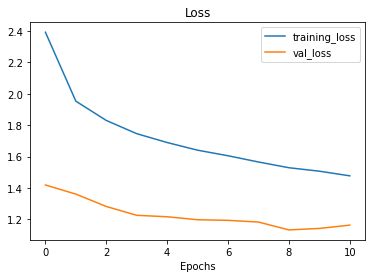

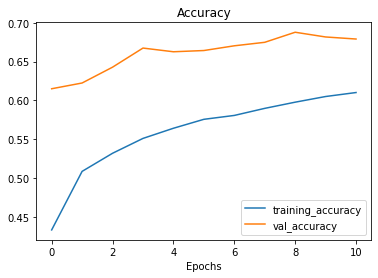

In [22]:
plot_loss_curves(history_2_101_foods_all_augmented)

## Fine-Tuning the model

In [23]:
# Save the new augmented model 
base_model_augmented.save("model_101_foods_augmented_dropout_model_v2")

INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_model_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_dropout_model_v2/assets


In [ ]:
# Load the augmented model
base_model_augmented = tf.keras.models.load_model("model_101_foods_augmented_dropout_model_v2")

In [ ]:
del history_3_101_foods_all_augmented
import gc
gc.collect()

118679

In [24]:
# Unfreeze 30 layers
base_model_augmented.trainable = True

for layer in base_model_augmented.layers[2].layers[:-60]:
  layer.trainable = False
for layer in base_model_augmented.layers[2].layers[-30:]:
  layer.trainable = False

In [25]:
for num, layer in enumerate(base_model_augmented.layers[2].layers):
  print(num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_add False
20 block3a_expand_conv False
21 block3a_expand_bn False
22 block3a_expand_activation False
23 block3a_project_conv False
24 block3a_project_bn False
25 block3b_expand_conv False
26 block3b_expand_bn False
27 block3b_expand_activation False
28 block3b_project_conv False
29 block3b_project_bn False
30 block3b_add False
31 block4a_expand_conv False
32 block4a_expand_bn False
33 block4a_expand_activation False
34 block4a_dwconv2 False
35 block4a_bn False
36 block4a_activation 

In [26]:
# Fine-tune for another 3 epochs or till called back
fine_tune_epochs = initial_epochs + 15

# Recompile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00075), # good was 0.0005 74.3-6%
                metrics=["accuracy"])

# Fit the model
history_3_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_dropout"), 
                                                             callback],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_dropout/20220514-131903
Epoch 11/35
2368/2368 [==============================] - 215s 85ms/step - loss: 1.3395 - accuracy: 0.6452 - val_loss: 1.0063 - val_accuracy: 0.7198
Epoch 12/35
2368/2368 [==============================] - 200s 84ms/step - loss: 1.1986 - accuracy: 0.6791 - val_loss: 0.9579 - val_accuracy: 0.7325
Epoch 13/35
2368/2368 [==============================] - 203s 85ms/step - loss: 1.1095 - accuracy: 0.6991 - val_loss: 0.9386 - val_accuracy: 0.7426
Epoch 14/35
2368/2368 [==============================] - 199s 83ms/step - loss: 1.0351 - accuracy: 0.7146 - val_loss: 0.9234 - val_accuracy: 0.7421
Epoch 15/35
2368/2368 [==============================] - 203s 85ms/step - loss: 0.9707 - accuracy: 0.7302 - val_loss: 0.9669 - val_accuracy: 0.7468
Epoch 16/35
2368/2368 [==============================] - 200s 84ms/step - loss: 0.9121 - accuracy: 0.7448 - val_loss: 0.9526 - va

In [ ]:
# Evaluate the augmented and fine-tuned model over the whole test set
base_model_augmented.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0812 - accuracy: 0.7062


[1.0812370777130127, 0.7061781883239746]

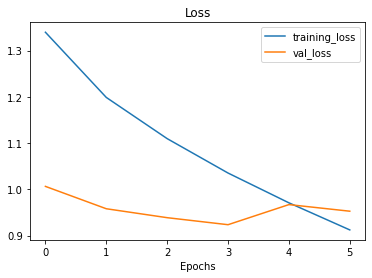

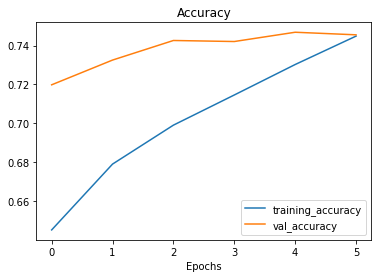

In [27]:
# Plot the loss curves of the new history
# The model trend appears to be much better than last time!
plot_loss_curves(history_3_101_foods_all_augmented)

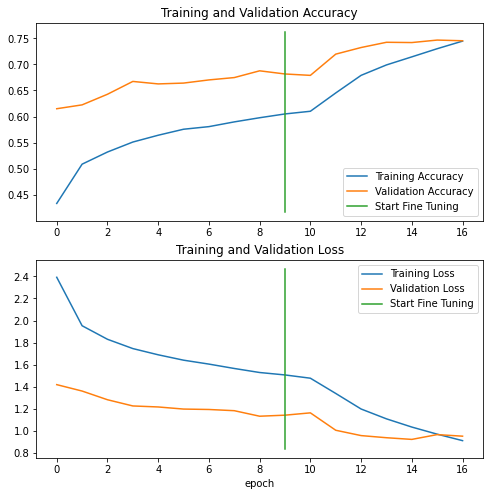

In [28]:
compare_historys(history_2_101_foods_all_augmented, history_3_101_foods_all_augmented, initial_epochs=history_2_101_foods_all_augmented.epoch[-1])

Comparing the history of the new model with the old non-trainable one, it can be seen that the model stops improving as much at around 5 epochs.

In [29]:
base_model_augmented.save("model_101_foods_augmented_model_fine_tuned_dropout_6030l_v2")


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_fine_tuned_dropout_6030l_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_fine_tuned_dropout_6030l_v2/assets


## How about unfreezing 20 more layers and increasing the epochs by 5

In [30]:
model_4_aug_fine_tune_dropout = tf.keras.models.load_model("model_101_foods_augmented_model_fine_tuned_dropout_6030l_v2")
# model_4_aug_fine_tune_dropout = base_model_augmented

In [ ]:
model_4_aug_fine_tune_dropout.load_weights("model_101_foods_augmented_model_fine_tuned_dropout_6030l_v2")

In [31]:
# Unfreeze the last 30-10 layers
model_4_aug_fine_tune_dropout.trainable = True

for layer in model_4_aug_fine_tune_dropout.layers[2].layers[:-30]:
  layer.trainable = False
for layer in model_4_aug_fine_tune_dropout.layers[2].layers[-15:]:
  layer.trainable = False

In [32]:
# Fine-tune till called back
fine_tune_epochs = history_3_101_foods_all_augmented.epoch[-1] + 15

# Recompile the model
model_4_aug_fine_tune_dropout.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # good was 0.00025
                metrics=["accuracy"])

# Fit the model
history_4_101_foods_all_augmented = model_4_aug_fine_tune_dropout.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_30Layers"), 
                                                                 callback],
                                                             initial_epoch=history_3_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_30Layers/20220514-134309
Epoch 16/30
2368/2368 [==============================] - 204s 82ms/step - loss: 0.9097 - accuracy: 0.7471 - val_loss: 0.8985 - val_accuracy: 0.7558
Epoch 17/30
2368/2368 [==============================] - 197s 82ms/step - loss: 0.8588 - accuracy: 0.7585 - val_loss: 0.9016 - val_accuracy: 0.7585
Epoch 18/30
2368/2368 [==============================] - 200s 83ms/step - loss: 0.8135 - accuracy: 0.7683 - val_loss: 0.9184 - val_accuracy: 0.7558


121478

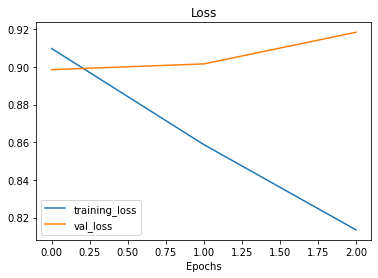

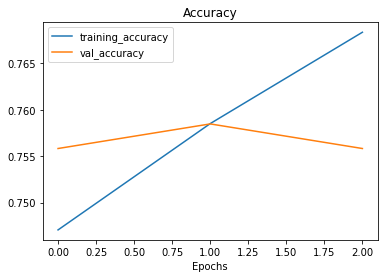

In [33]:
# The last epochs seems to barely make a dent but the over all trend apepear 
# to be good
plot_loss_curves(history_4_101_foods_all_augmented)

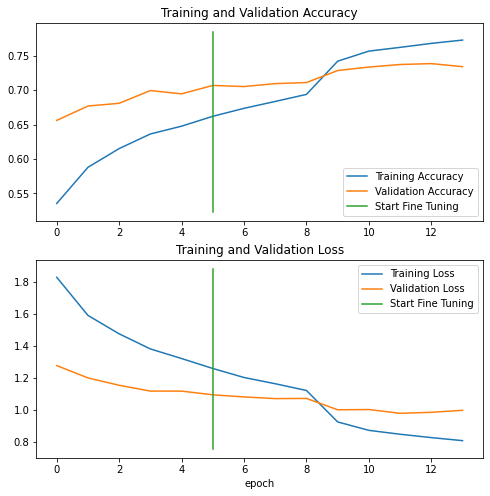

In [ ]:
compare_historys(history_3_101_foods_all_augmented,history_4_101_foods_all_augmented, initial_epochs=history_3_101_foods_all_augmented.epoch[0])

In [ ]:
# Save the model
model_4_aug_fine_tune_dropout.save("model_101_foods_augmented_model_30l_Layers_new_v2")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_30l_Layers_new_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_30l_Layers_new_v2/assets


In [ ]:
model_4_aug_fine_tune_dropout.load_weights("model_101_foods_augmented_model_30l_Layers_new_v2")

In [ ]:
# Colab commands to download the model
!zip -r /content/model_tuned_30l_new_final.zip /content/model_101_foods_augmented_model_30l_Layers_new

# Download the file 
from google.colab import files
files.download("/content/model_tuned_30l_new_final.zip")

  adding: content/model_101_foods_augmented_model_30l_Layers_new/ (stored 0%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/variables/variables.index (deflated 74%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/keras_metadata.pb (deflated 96%)
  adding: content/model_101_foods_augmented_model_30l_Layers_new/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gc
gc.collect()

14828

In [38]:
# Final model with 5 layers and till called back
#model_5_aug_fine_tuned_dropout = tf.keras.models.load_model("model_101_foods_augmented_model_30l_Layers_new_v2")
model_5_aug_fine_tuned_dropout = model_4_aug_fine_tune_dropout

In [39]:
# Unfreeze the last 60-30 layers layers to learn fine details
model_5_aug_fine_tuned_dropout.trainable = True

for layer in model_5_aug_fine_tuned_dropout.layers[2].layers[:-15]:
  layer.trainable = False

In [ ]:
# Unfreeze the last 60-30 layers layers to learn fine details
model_5_aug_fine_tuned_dropout.trainable = False

for layer in model_5_aug_fine_tuned_dropout.layers[2].layers[-116:-74]:
  layer.trainable = True
for layer in model_5_aug_fine_tuned_dropout.layers[0:2]:
  layer.trainable = True
for layer in model_5_aug_fine_tuned_dropout.layers[3:]:
  layer.trainable = True
# for layer in model_5_aug_fine_tuned_dropout.layers[2].layers[-75:]:
#   layer.trainable = False

In [ ]:
for layer in model_5_aug_fine_tuned_dropout.layers:
  print(layer.trainable, layer.name)

True input_layer
True data_agumentation
False model_16
False global_average_pooling_2D
False top_added_bn
False dense_17
False dense_18
False softmax_float32


In [ ]:
for i, layer in enumerate(model_5_aug_fine_tuned_dropout.layers[2].layers):
  print(i, layer.trainable, layer.name)

0 False input_9
1 False rescaling_8
2 False normalization_8
3 False stem_conv
4 False stem_bn
5 False stem_activation
6 False block1a_project_conv
7 False block1a_project_bn
8 False block1a_project_activation
9 False block2a_expand_conv
10 False block2a_expand_bn
11 False block2a_expand_activation
12 False block2a_project_conv
13 False block2a_project_bn
14 False block2b_expand_conv
15 False block2b_expand_bn
16 False block2b_expand_activation
17 False block2b_project_conv
18 False block2b_project_bn
19 False block2b_add
20 False block3a_expand_conv
21 False block3a_expand_bn
22 False block3a_expand_activation
23 False block3a_project_conv
24 False block3a_project_bn
25 False block3b_expand_conv
26 False block3b_expand_bn
27 False block3b_expand_activation
28 False block3b_project_conv
29 False block3b_project_bn
30 False block3b_add
31 False block4a_expand_conv
32 False block4a_expand_bn
33 False block4a_expand_activation
34 False block4a_dwconv2
35 False block4a_bn
36 False block4a_a

In [40]:
# Fine-tune for another 4 epochs (or till called back)
fine_tune_epochs = history_4_101_foods_all_augmented.epoch[-1]-1 + 15

# Recompile the model
model_5_aug_fine_tuned_dropout.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025), # 0.0001 was good
                metrics=["accuracy"])

# Fit the model
history_5_101_foods_all_augmented = model_5_aug_fine_tuned_dropout.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers"
                                                             ),
                                                             callback],
                                                             initial_epoch=history_4_101_foods_all_augmented.epoch[-1]-1)


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220514-135724
Epoch 17/31
2368/2368 [==============================] - 209s 84ms/step - loss: 0.9095 - accuracy: 0.7480 - val_loss: 0.8869 - val_accuracy: 0.7646
Epoch 18/31
2368/2368 [==============================] - 193s 81ms/step - loss: 0.8265 - accuracy: 0.7667 - val_loss: 0.8877 - val_accuracy: 0.7643
Epoch 19/31
2368/2368 [==============================] - 195s 82ms/step - loss: 0.7737 - accuracy: 0.7807 - val_loss: 0.9007 - val_accuracy: 0.7677


In [41]:
# Fine-tune for another 4 epochs (or till called back)
fine_tune_epochs = history_5_101_foods_all_augmented.epoch[-1]-1 + 15

# Recompile the model
model_5_aug_fine_tuned_dropout.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_5_101_foods_all_augmented = model_5_aug_fine_tuned_dropout.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers"
                                                             ),
                                                             callback],
                                                             initial_epoch=history_5_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220514-140938
Epoch 19/32
2368/2368 [==============================] - 204s 82ms/step - loss: 0.7725 - accuracy: 0.7829 - val_loss: 0.8656 - val_accuracy: 0.7680
Epoch 20/32
2368/2368 [==============================] - 193s 81ms/step - loss: 0.7376 - accuracy: 0.7926 - val_loss: 0.8552 - val_accuracy: 0.7762
Epoch 21/32
2368/2368 [==============================] - 196s 82ms/step - loss: 0.7038 - accuracy: 0.7992 - val_loss: 0.8499 - val_accuracy: 0.7752
Epoch 22/32
2368/2368 [==============================] - 193s 81ms/step - loss: 0.6799 - accuracy: 0.8056 - val_loss: 0.8738 - val_accuracy: 0.7722
Epoch 23/32
2368/2368 [==============================] - 212s 89ms/step - loss: 0.6537 - accuracy: 0.8125 - val_loss: 0.8755 - val_accuracy: 0.7736


In [ ]:
# Evaluate the performance of model_4 and model_5 since validation only looks at 15% of the test data
model_4_aug_fine_tune_dropout.evaluate(test_data), model_5_aug_fine_tuned_dropout.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 0.9363 - accuracy: 0.7516


([0.9362660050392151, 0.7516039609909058],
 [0.936265766620636, 0.7516039609909058])

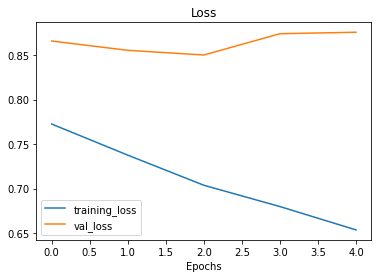

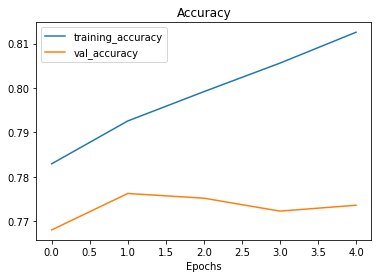

In [44]:
plot_loss_curves(history_5_101_foods_all_augmented)

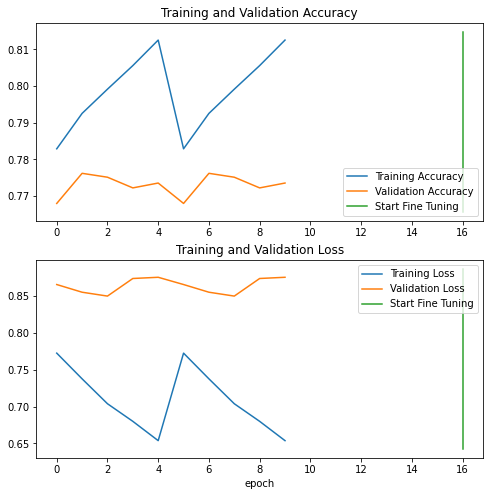

In [46]:
compare_historys(history_5_101_foods_all_augmented,history_5_101_foods_all_augmented, initial_epochs=history_5_101_foods_all_augmented.epoch[-1]-5)

In [59]:
model_6 = tf.keras.models.load_model("model_101_foods_augmented_model_60l_v2")

In [60]:
# perform the experiment before once again 
# Unfreeze the last 20 layers
model_6.trainable = True
for layer in model_6.layers[2].layers[:-80]:
  layer.trainable = False

# Recompile the model
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=history_5_101_foods_all_augmented.epoch[-1]+10,
                        validation_data=test_data,
                        validation_steps=int(0.15*len(test_data)),
                        callbacks=[create_tensorboard_callback(
                            "training_log_aug",
                            "efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers"
                        ),
                        callback],
                        initial_epoch=history_5_101_foods_all_augmented.epoch[-1]+1)


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220514-150122
Epoch 24/32
2368/2368 [==============================] - 235s 93ms/step - loss: 0.6501 - accuracy: 0.8135 - val_loss: 0.8333 - val_accuracy: 0.7807
Epoch 25/32
2368/2368 [==============================] - 218s 91ms/step - loss: 0.5985 - accuracy: 0.8280 - val_loss: 0.8304 - val_accuracy: 0.7807
Epoch 26/32
2368/2368 [==============================] - 219s 91ms/step - loss: 0.5629 - accuracy: 0.8375 - val_loss: 0.8454 - val_accuracy: 0.7805
Epoch 27/32
2368/2368 [==============================] - 218s 91ms/step - loss: 0.5299 - accuracy: 0.8456 - val_loss: 0.8628 - val_accuracy: 0.7799


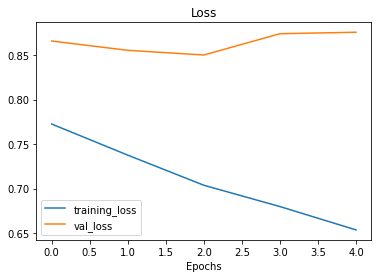

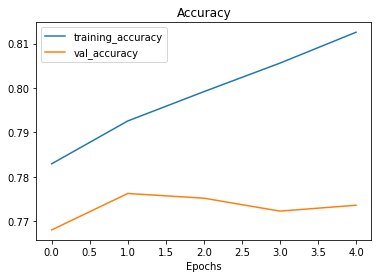

In [61]:
 plot_loss_curves(history_5_101_foods_all_augmented)

In [42]:
# Save the model
model_5_aug_fine_tuned_dropout.save("model_101_foods_augmented_model_80l_v2")

# Colab commands to download the model
!zip -r /content/model_tuned_60l_v2.zip /content/model_101_foods_augmented_model_60l_v2
# !zip -r /content/training_log_aug.zip /content/training_log_aug

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_60l_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_60l_v2/assets


  adding: content/model_101_foods_augmented_model_60l_v2/ (stored 0%)
  adding: content/model_101_foods_augmented_model_60l_v2/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_60l_v2/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_60l_v2/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_60l_v2/variables/variables.index (deflated 75%)
  adding: content/model_101_foods_augmented_model_60l_v2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_60l_v2/keras_metadata.pb (deflated 96%)


In [43]:
# Download the file 
from google.colab import files
files.download("/content/model_tuned_60l_v2.zip")
# files.download("/content/training_log_aug.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
# Save the model
model_6.save("model_101_foods_augmented_model_80l_v2")
# Colab commands to download the model
!zip -r /content/model_tuned_80l_v2.zip /content/model_101_foods_augmented_model_80l_v2
files.download("/content/model_tuned_80l_v2.zip")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_80l_v2/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_80l_v2/assets


  adding: content/model_101_foods_augmented_model_80l_v2/ (stored 0%)
  adding: content/model_101_foods_augmented_model_80l_v2/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_80l_v2/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_80l_v2/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_80l_v2/variables/variables.index (deflated 77%)
  adding: content/model_101_foods_augmented_model_80l_v2/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model_101_foods_augmented_model_80l_v2/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Upload the logs on tensorboard and visualize the progress

In [ ]:
!tensorboard dev upload --logdir /content/training_log_aug \
--name "Transfer Learning Experiment with 101 Food Types" \
--description "A series of different transfer learning experiments with data augmentation and fine-tuning" \
--one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/training_log_aug

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=8gmjlkiXSVhuMu1jWIdnnezgABkn81&prompt=consent&access_

# Visualize the last model's prediction
- Create a probability vector
- Choose the maximum from the vector, to find the class
- unbatch the categorical test data saved previously and extract the labels
- Use the make_confusion_matrix from the helperFunction

In [62]:
# Make predictions with model
preds_probs = model_5_aug_fine_tuned_dropout.predict(test_data, verbose=1) # set to 1 to see the time left

790/790 [==============================] - 57s 69ms/step


In [49]:
test_data_categorical

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [63]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# To get the test labels the test_data needs to be unbatched
y_labels = []
for images, labels in test_data_categorical.unbatch():
    y_labels.append(labels.numpy().argmax()) # 

In [70]:
y_labels[:5],len(y_labels), pred_classes[:5],class_names

([65, 70, 34, 69, 23],
 25250,
 array([90,  8, 65,  0, 57]),
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'ho

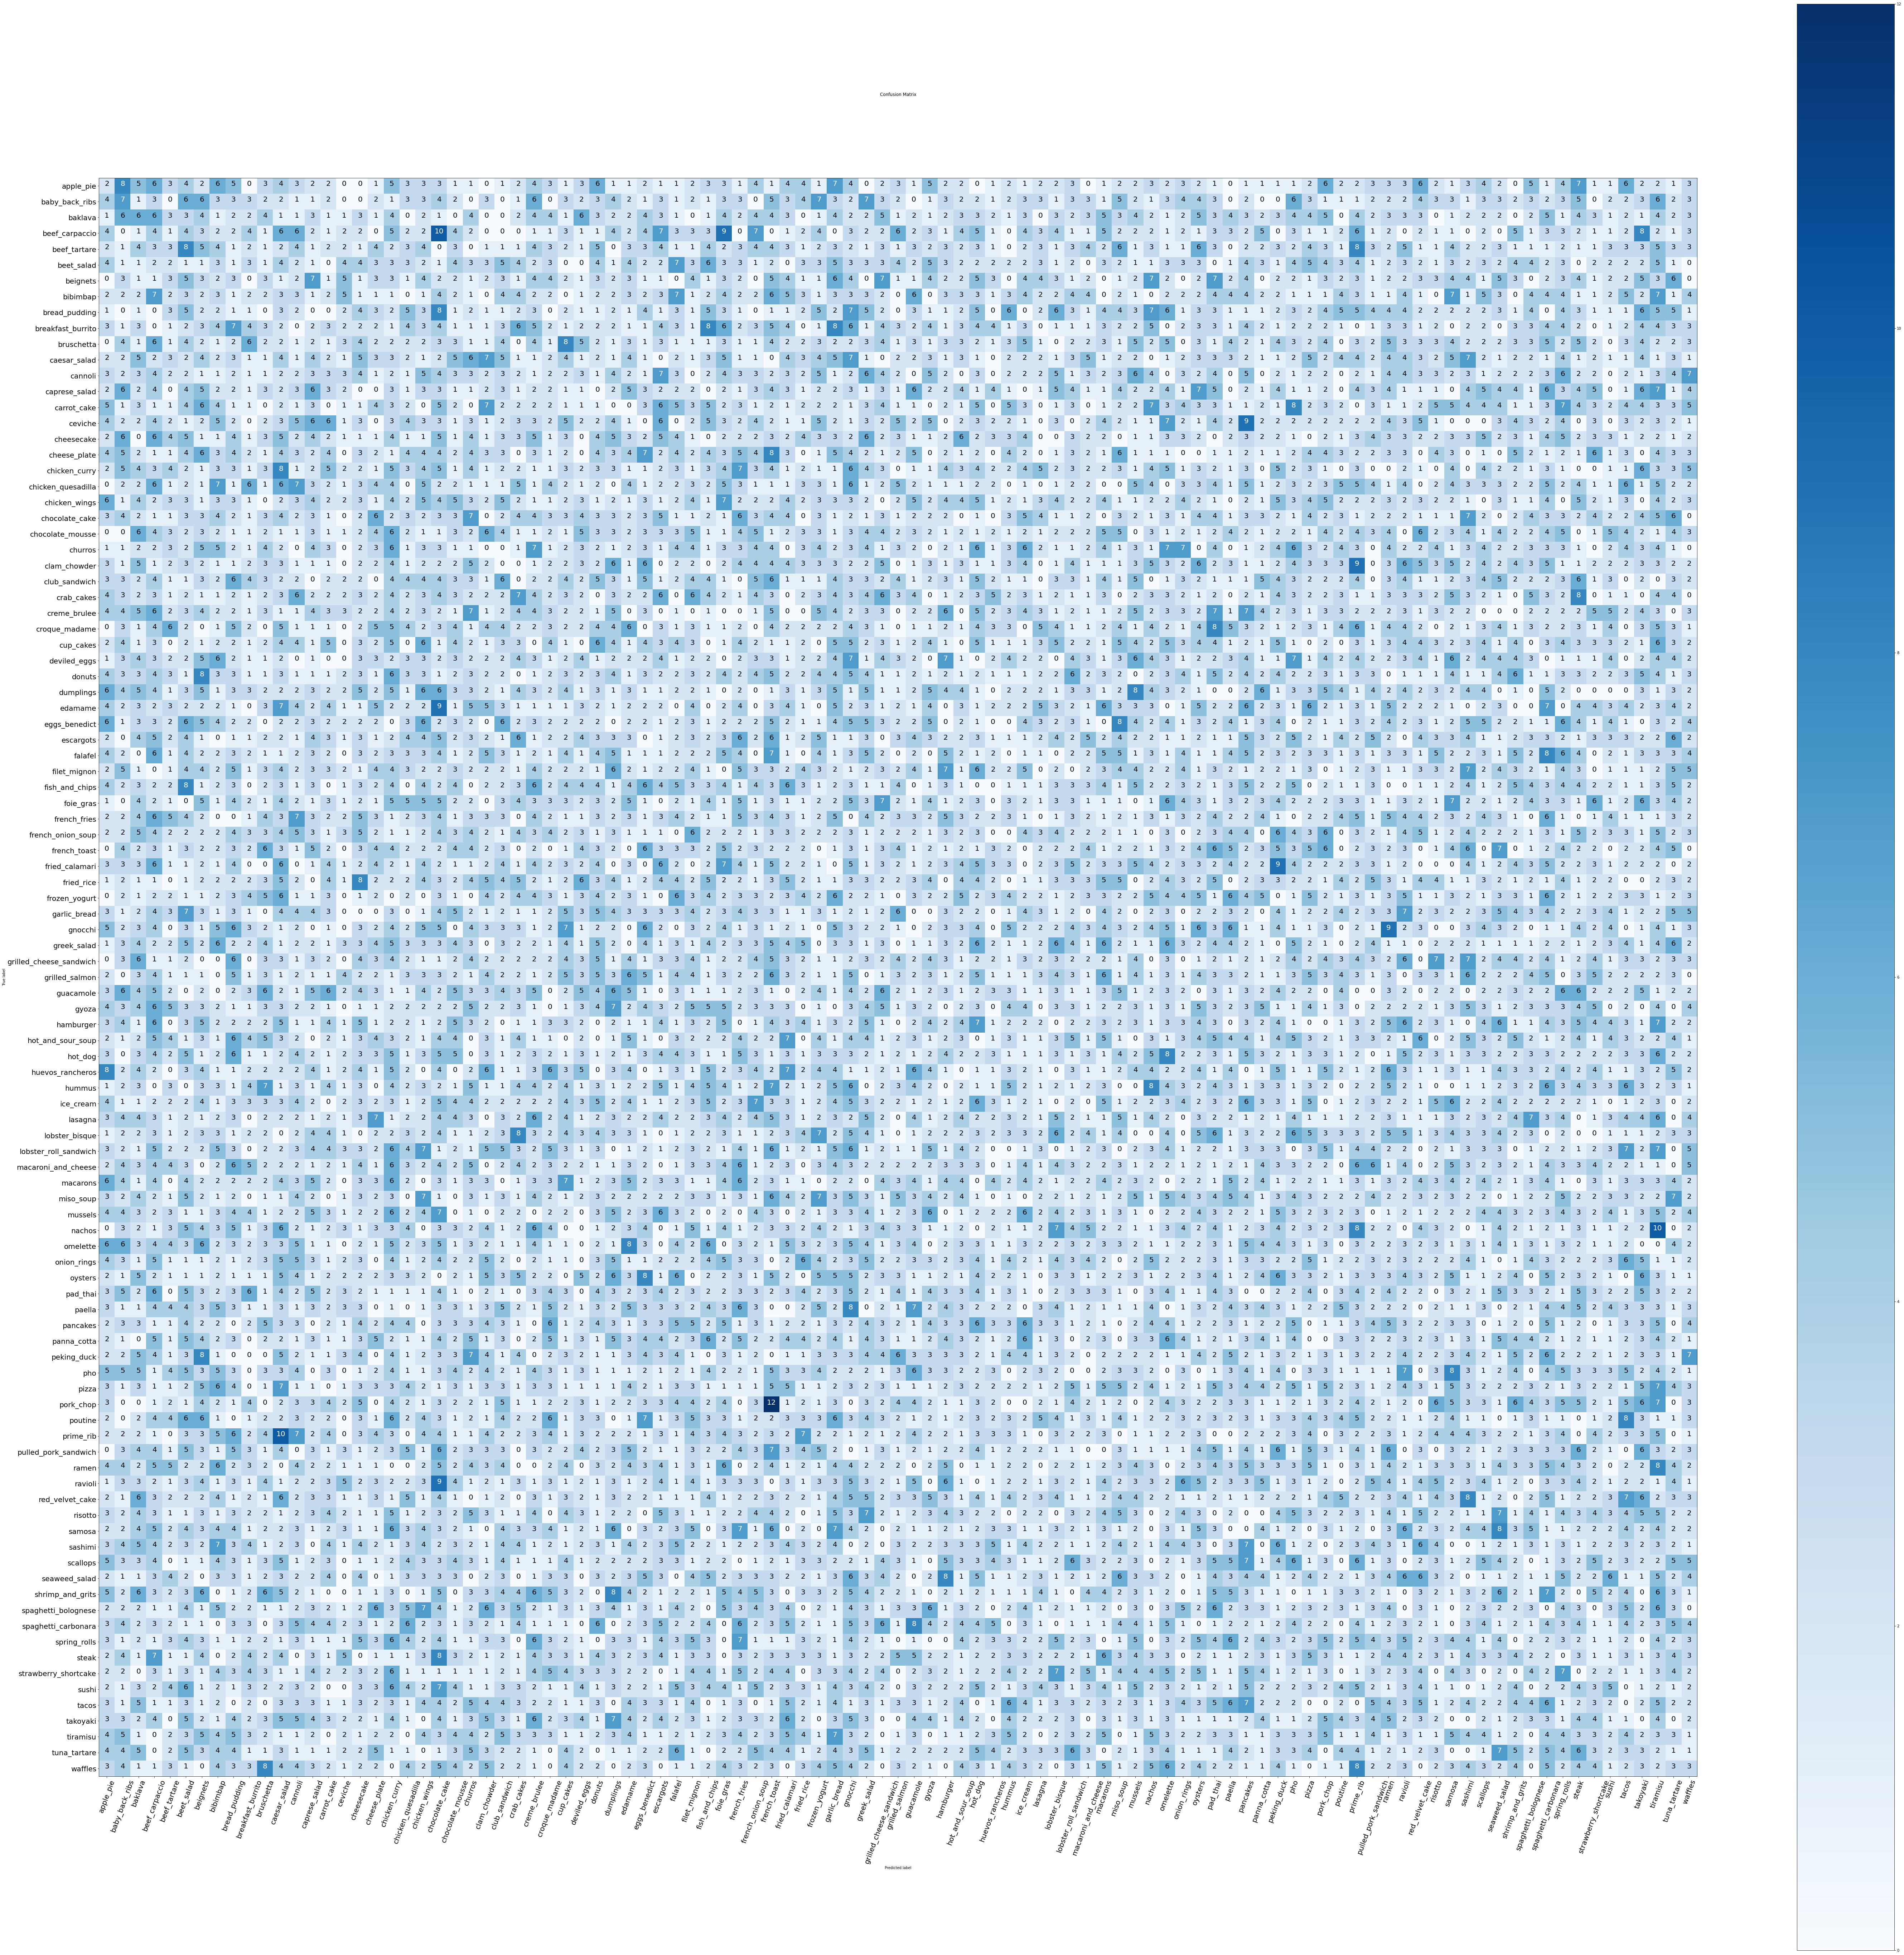

In [64]:
from helperFunctions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,
                      rotate=True)

In [76]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrixs(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, rotate=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred) # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  if rotate:
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

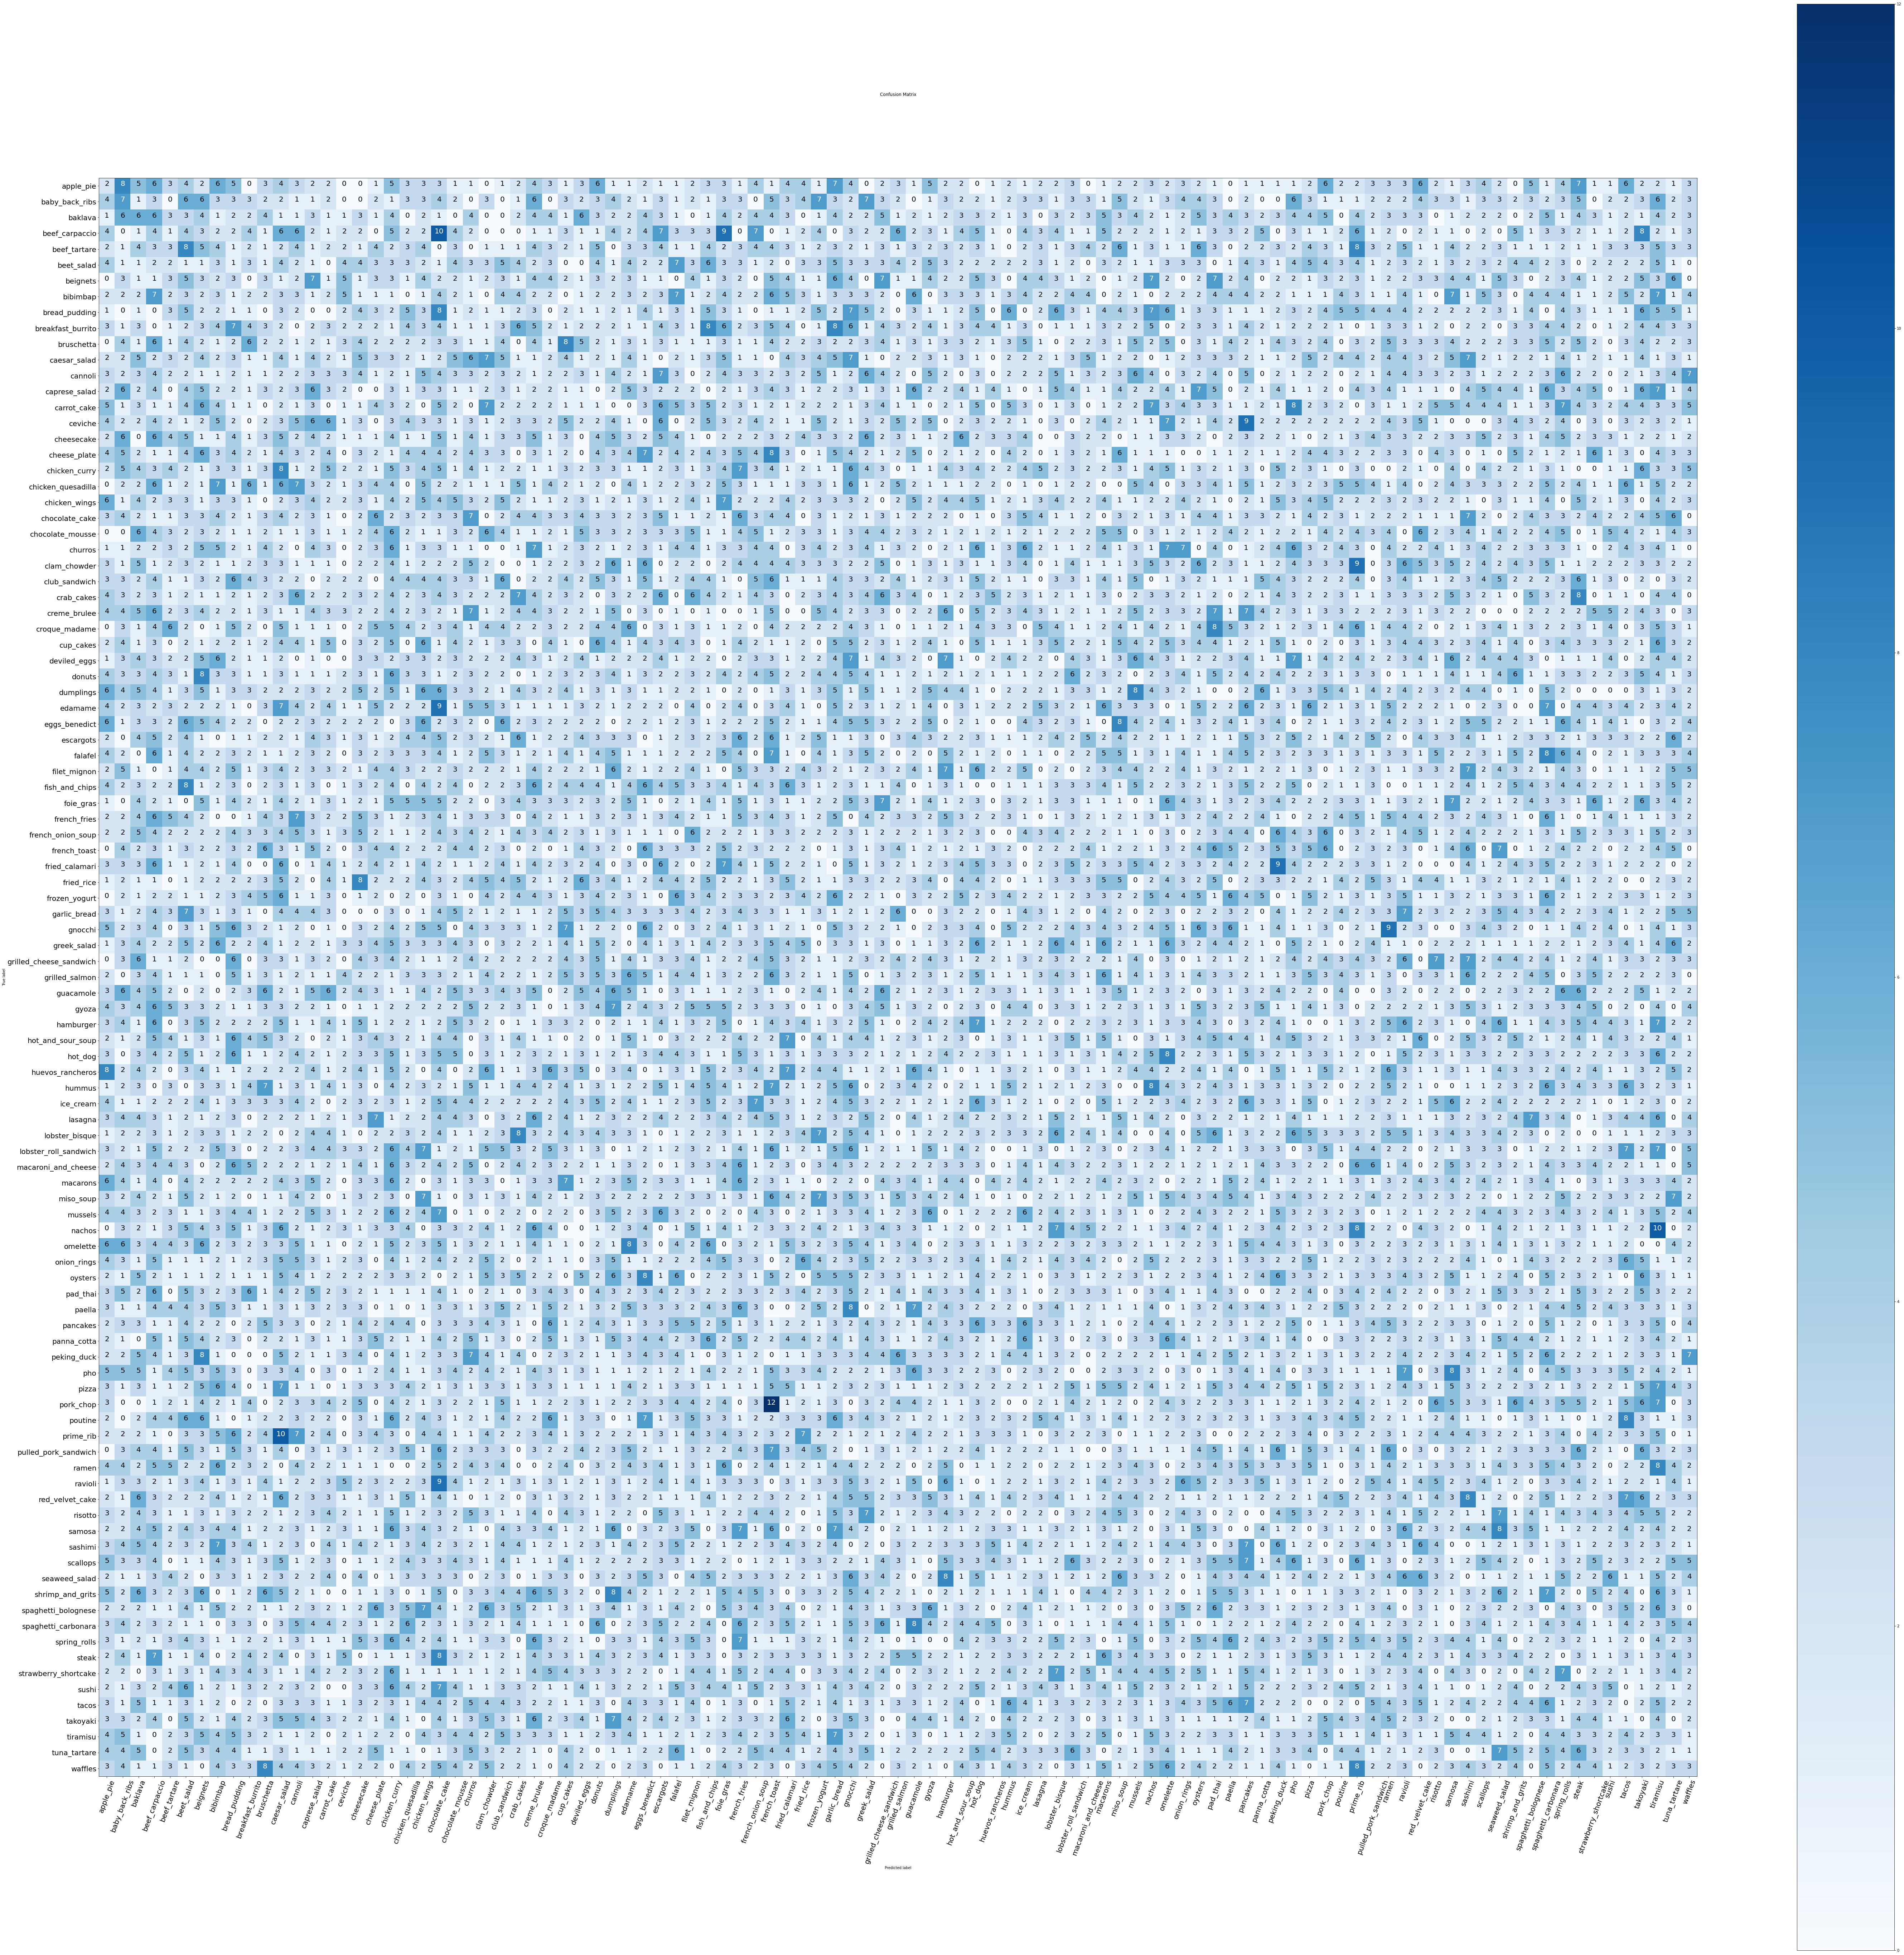

In [77]:
make_confusion_matrixs(y_true=y_labels,
                      y_pred=pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,
                      rotate=True)